In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
import cmocean.cm as cmo
import seaborn as sns
from glob import glob

# Download Natural Earth Shapefiles from https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-bathymetry/
## https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_bathymetry_all.zip
## Save in local directory 'ne_10m_bathymetry_all'

# Version 1: depth levels in the colorbar are linearly spaced

## Load shapefiles for each depth

In [2]:
shp_dict = {}
files = glob('ne_10m_bathymetry_all/*.shp')
assert len(files) > 0
files.sort()
for f in files:
    depth = f.split('_')[-1].split('.')[0]
    # depth = '-' + f.split('_')[-1].split('.')[0]
    # depths.append(depth)
    nei = cart.io.shapereader.Reader(f)
    shp_dict[depth] = nei

## Get depths and construct colormap using seaborn and cmocean

In [3]:
depths = [d for d in shp_dict.keys()][::-1]
colors = sns.mpl_palette('cmo.deep',n_colors=len(depths))
cmap   = sns.mpl_palette('cmo.deep_r',n_colors=len(depths),as_cmap=True)

## Plot

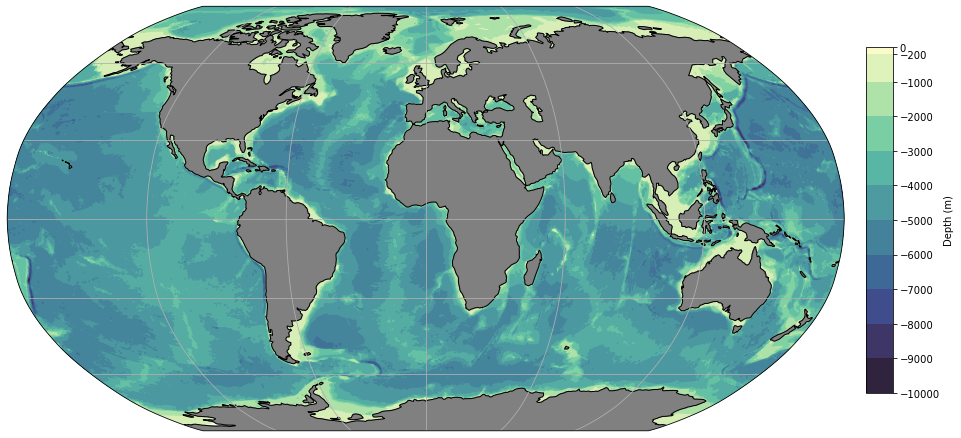

In [7]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Robinson()},figsize=(15,8))

# Iterate and plot feature for each depth level
i = 0
for depth in depths:
    ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
    i+=1
# ax.set_facecolor('grey')
# ax.add_feature(cart.feature.LAND,color='grey')
ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='LAND',scale='110m'),color='grey')
ax.coastlines(lw=1,resolution='110m')
ax.gridlines(draw_labels=False)

# Add custom colorbar
axi = fig.add_axes([0.92,0.2,0.025,0.6])
# axi = fig.add_axes([0.8,0.2,0.025,0.6])
norm = matplotlib.colors.Normalize(vmin=-10000,vmax=0)
cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap,norm=norm,
        boundaries=(-np.array(depths).astype(int)).tolist()[::-1],
        ticks=-np.array(depths).astype(int),
        spacing='proportional',
        extend='neither',
        label='Depth (m)'
        )

# Save Figure
fig.savefig('bathymetry_from_ne_global_v1.pdf',dpi=200,bbox_inches='tight')

ax.set_rasterized(True) # convert vector bathymetries to raster (saves a lot of disk space) while leaving labels as vectors
fig.savefig('bathymetry_from_ne_global_v1_raster.pdf',dpi=200,bbox_inches='tight')
fig.savefig('bathymetry_from_ne_global_v1.png',dpi=200,bbox_inches='tight') # save whole figure as raster

# Version 2: depth levels in the colorbar are spaced as in the data

## Load shapefiles for each depth

In [8]:
shp_dict = {}
files = glob('ne_10m_bathymetry_all/*.shp')
assert len(files) > 0
files.sort()
depths = []
for f in files:
    # depth = f.split('_')[-1].split('.')[0]
    depth = '-' + f.split('_')[-1].split('.')[0]
    depths.append(depth)
    nei = cart.io.shapereader.Reader(f)
    shp_dict[depth] = nei
depths = np.array(depths)[::-1] # sort from surface to bottom
N = len(depths)

## Construct colormap

In [9]:
depth_fraction = depths.astype(float) / depths.astype(float).min() # spacing from 0 to 1 (depths are coded negative here)

colors_depths = cmo.deep_r(depth_fraction) # color values at fractional depths

# custom colormap from (fraction,color) pairs
cmap_depths = matplotlib.colors.LinearSegmentedColormap.from_list('depths',[[depth_fraction[i],colors_depths[i].tolist()] for i in range(N)],N=N)

## Plot

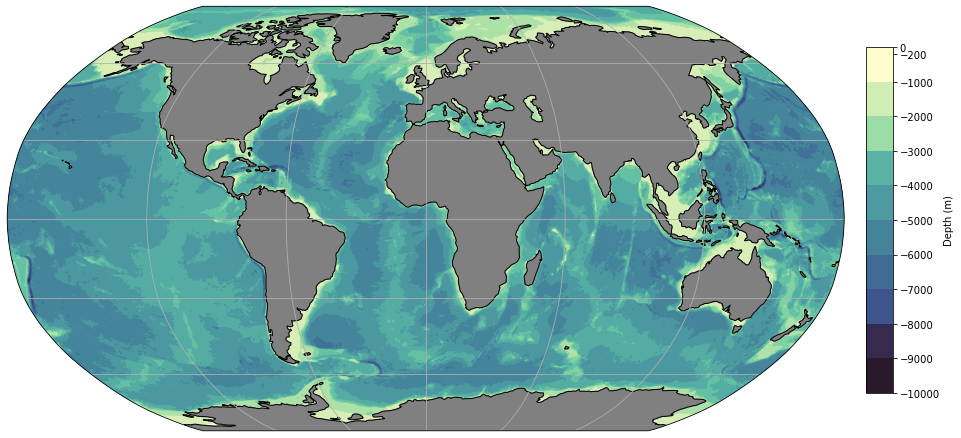

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Robinson()},figsize=(15,8))

# Iterate and plot feature for each depth level
i = 0
for depth in depths:
    ax.add_geometries(shp_dict[depth].geometries(),crs=ccrs.PlateCarree(),color=colors[i])
    i+=1
# ax.set_facecolor('grey')
ax.add_feature(cart.feature.NaturalEarthFeature(category='physical',name='LAND',scale='110m'),color='grey')
ax.coastlines(lw=1,resolution='110m')
ax.gridlines(draw_labels=False)

# Add custom colorbar
axi = fig.add_axes([0.92,0.2,0.025,0.6])
cbar = matplotlib.colorbar.ColorbarBase(ax=axi,cmap=cmap_depths,
        boundaries=depths.astype(int)[::-1],
        ticks=depths.astype(int),
        spacing='proportional',
        extend='neither',
        label='Depth (m)'
        )

# Save Figure
fig.savefig('bathymetry_from_ne_global_v2.pdf',dpi=200,bbox_inches='tight')

ax.set_rasterized(True) # convert vector bathymetries to raster (saves a lot of disk space) while leaving labels as vectors
fig.savefig('bathymetry_from_ne_global_v2_raster.pdf',dpi=200,bbox_inches='tight')
fig.savefig('bathymetry_from_ne_global_v2.png',dpi=200,bbox_inches='tight') # save whole figure as raster